In [ ]:
# Copyright 2021 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feedback or issues?

For any feedback or questions, please fill up this [form](https://forms.gle/hXDnv1T4WanMwTi79). If you provided an email address, we will follow up with you.

# ML parameter and metric tracking via MB SDK

To use this Jupyter notebook, copy the notebook to an AI Platform(Unified) Notebooks instance with Tensorflow installed and open it. You can run each step, or cell, and see its results. To run a cell, use Shift+Enter. Jupyter automatically displays the return value of the last line in each cell. For more information about running notebooks in AI Platform(Unified) Notebook, see the [AI Platform(Unified) Notebook guide](https://cloud.google.com/ai-platform-unified/docs/general/notebooks).


This notebook demonstrate how to track metrics and parameters for ML training jobs. And also how to perform detail analysis using those data.



Note: you may incur charges for training, prediction, storage or usage of other GCP products in connection with testing this SDK.

### Install Model Builder SDK

This section install the Model Builder SDK. Refer to the [Model Builder SDK User Guide](https://docs.google.com/document/d/1tFhzwCbR1jU-_BLkxmEriA9Y3NDWse2YYEYyKXkRybk) for more details.

After the SDK installation the kernel will be automatically restarted.

In [4]:
%%capture
!pip3 uninstall -y google-cloud-aiplatform --user
!pip3 install --user git+https://github.com/googleapis/python-aiplatform.git@dev-test --user
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

### Enter Your Project and GCS Bucket

Enter your Project Id in the cell below. Then run the cell to make sure the Cloud SDK uses the right project for all the commands in this notebook.

In [1]:
MY_PROJECT = 'rthallam-demo-project' # Please change this to your own test project
MY_STAGING_BUCKET = 'gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77'  # bucket should be in same region as ucaip

In [2]:
import sys
if 'google.colab' in sys.modules:
  from google.colab import auth
  auth.authenticate_user()

## Set up SDK workspace

In [3]:
from google.cloud import aiplatform
import tensorflow as tf
import uuid

### Initialize Model Builder SDK and set an Experiment

Initialize the *client* for AI Platform (Unified).

In [4]:
aiplatform.constants.API_BASE_PATH = "staging-aiplatform.sandbox.googleapis.com" # set api endpoint to staging
# aiplatform.constants.API_BASE_PATH = "aiplatform.googleapis.com"

In [5]:
aiplatform.init(project=MY_PROJECT, experiment="metadata-tracking-experiment", staging_bucket=MY_STAGING_BUCKET)

INFO:root:MetadataStore default not found.
INFO:root:Resource metadata-tracking-experiment not found.
INFO:root:Creating Resource metadata-tracking-experiment


# Tracking parameters and metrics for a model trained locally

Users can use this SDK to track metrics and parameters for models trained locally.

## Load and process training dataset

In [6]:
import pathlib
import numpy as np
import pandas as pd
from tensorflow.python.keras import layers, Sequential
from tensorflow.python.keras.utils import data_utils


In [7]:
def read_data(uri):
    dataset_path = data_utils.get_file("auto-mpg.data", uri)
    column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                    'Acceleration', 'Model Year', 'Origin']
    raw_dataset = pd.read_csv(dataset_path, names=column_names, na_values = "?",
                              comment='\t', sep=" ", skipinitialspace=True)
    dataset = raw_dataset.dropna()
    dataset['Origin'] = dataset['Origin'].map(
        lambda x: {1: 'USA', 2: 'Europe', 3: 'Japan'}.get(x))
    dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')        
    return dataset


dataset = read_data("http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
def train_test_split(dataset, split_frac=0.8, random_state=0):    
    train_dataset = dataset.sample(frac=split_frac, random_state=random_state)
    test_dataset = dataset.drop(train_dataset.index)
    train_labels = train_dataset.pop('MPG')
    test_labels = test_dataset.pop('MPG')
    
    return train_dataset, test_dataset, train_labels, test_labels

train_dataset, test_dataset, train_labels, test_labels = train_test_split(dataset)

In [9]:
def normalize_dataset(train_dataset, test_dataset):
    train_stats = train_dataset.describe()
    train_stats = train_stats.transpose()
    def norm(x):
        return (x - train_stats['mean']) / train_stats['std']
    normed_train_data = norm(train_dataset)
    normed_test_data = norm(test_dataset)
    
    return normed_train_data, normed_test_data

normed_train_data, normed_test_data = normalize_dataset(train_dataset,
                                                        test_dataset)

## Define ML model and training steps

In [10]:
def train(train_data, train_labels, num_units=64, activation='relu',
          dropout_rate=0.0, validation_split = 0.2, epochs=1000):
    
    model = Sequential([
        layers.Dense(num_units, activation=activation,
                     input_shape=[len(train_dataset.keys())]),
        layers.Dropout(rate=dropout_rate),
        layers.Dense(num_units, activation=activation),
        layers.Dense(1)
    ])


    model.compile(loss='mse',
                optimizer='adam',
                metrics=['mae', 'mse'])
    print(model.summary())
    
    history = model.fit(
      train_data, train_labels,
      epochs=epochs, validation_split=validation_split)

    return model, history

## Start model training in multiple runs and log training parameters and metrics

In [11]:
parameters = [
             {'num_units':16, 'epochs':3, 'dropout_rate':0.1}, 
             {'num_units':16, 'epochs':10, 'dropout_rate':0.1}, 
             {'num_units':16, 'epochs':10, 'dropout_rate':0.2},
             {'num_units':32, 'epochs':10, 'dropout_rate':0.1},
             {'num_units':32, 'epochs':10, 'dropout_rate':0.2},
            ]

for i, params in enumerate(parameters):
  aiplatform.start_run(run=f'run-{i}')
  aiplatform.log_params(params)
  model, history = train(normed_train_data, train_labels, num_units=params['num_units'],
                        activation='relu', epochs=params['epochs'], dropout_rate=params['dropout_rate'])
  aiplatform.log_metrics({metric: values[-1]
                            for metric, values in history.history.items()})
  
  loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2) 
  aiplatform.log_metrics({'eval_loss':loss, 'eval_mae':mae, 'eval_mse':mse})

INFO:root:Resource metadata-tracking-experiment-run-0 not found.
INFO:root:Creating Resource metadata-tracking-experiment-run-0
INFO:root:Resource metadata-tracking-experiment-run-0-metrics not found.
INFO:root:Creating Resource metadata-tracking-experiment-run-0-metrics
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                160       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 449
Trainable params: 449
Non-trainable params: 0
__________________________________________________

## Extract parameters and metrics into a dataframe for analysis

In [13]:
experiment_df = aiplatform.get_experiment_df()
experiment_df

,experiment_name,run_name,param.epochs,param.dropout_rate,param.num_units,metric.mse,metric.val_mae,metric.val_mse,metric.eval_loss,metric.mae,metric.eval_mse,metric.loss,metric.val_loss,metric.eval_mae
0,metadata-tracking-experiment,run-4,10.0,0.2,32.0,352.720612,16.743032,336.388397,349.349823,17.282282,349.349823,352.720612,336.388397,17.133062
1,metadata-tracking-experiment,run-3,10.0,0.1,32.0,358.596191,16.499369,343.247681,354.912109,17.038406,354.912109,358.596191,343.247681,16.895674
2,metadata-tracking-experiment,run-2,10.0,0.2,16.0,525.632446,21.534233,540.731506,559.951416,21.311123,559.951416,525.632446,540.731506,21.906973
3,metadata-tracking-experiment,run-1,10.0,0.1,16.0,449.058929,19.507488,445.419037,465.491638,19.622105,465.491638,449.058929,445.419037,19.950357
4,metadata-tracking-experiment,run-0,3.0,0.1,16.0,573.128052,23.001535,592.654114,608.440430,22.627436,608.440430,573.128052,592.654114,23.255013


## Parallel Coordinates Example

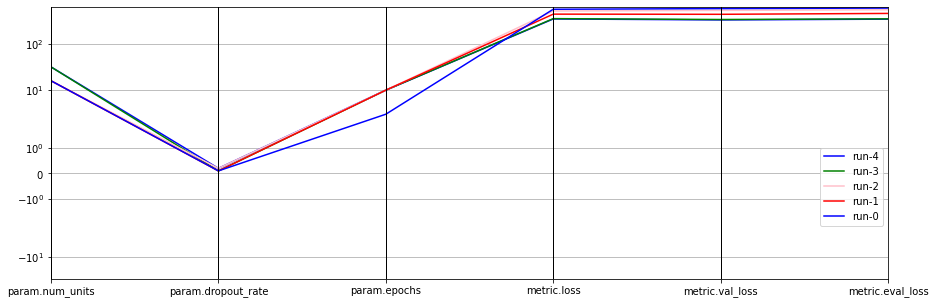

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [15, 5]

ax = pd.plotting.parallel_coordinates(
    experiment_df.reset_index(level=0),
    'run_name', cols=['param.num_units', 'param.dropout_rate',
                             'param.epochs', 'metric.loss',
                             'metric.val_loss', 'metric.eval_loss'],
    color=['blue', 'green', 'pink', 'red'],
    )
ax.set_yscale('symlog')
ax.legend(bbox_to_anchor=(1.0, 0.5))

## View data in pantheon UI

Parameters and metrics can also be viewed in pantheon UI. 

In [15]:
print("Autopush UI:")
print(f'https://pantheon-hourly-sso.corp.google.com/ai/platform/locations/us-central1/experiments/experiment1/parameters?e=UcaipUiExperimentsLaunch::UcaipUiExperimentsEnabled,UcaipStudiesListDetailsLaunch::UcaipStudiesListDetailsEnabled&mods=-ai_platform_fake_service,-ai_platform_staging_service&p2env=features%2F1566058016537%2Fbuild_units%2Fmain%2Fenvironments%2Fautopush&project={MY_PROJECT}')
print("Staging UI:")
print(f'https://pantheon.corp.google.com/ai/platform/experiments/experiments?e=UcaipCustomBatchPredictionLaunch::UcaipCustomBatchPredictionEnabled,UcaipGaLaunch::UcaipGaEnabled,UcaipUiExperimentsLaunch::UcaipUiExperimentsEnabled,UcaipStudiesListDetailsLaunch::UcaipStudiesListDetailsEnabled&mods=-ai_platform_fake_service,ai_platform_staging_service&p2env=features%2F1566058016537%2Fbuild_units%2Fmain%2Fenvironments%2Fstaging&project={MY_PROJECT}')
print("Prod UI:")
print(f'https://pantheon.corp.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project={MY_PROJECT}')

Autopush UI:
https://pantheon-hourly-sso.corp.google.com/ai/platform/locations/us-central1/experiments/experiment1/parameters?e=UcaipUiExperimentsLaunch::UcaipUiExperimentsEnabled,UcaipStudiesListDetailsLaunch::UcaipStudiesListDetailsEnabled&mods=-ai_platform_fake_service,-ai_platform_staging_service&p2env=features%2F1566058016537%2Fbuild_units%2Fmain%2Fenvironments%2Fautopush&project=rthallam-demo-project
Staging UI:
https://pantheon.corp.google.com/ai/platform/experiments/experiments?e=UcaipCustomBatchPredictionLaunch::UcaipCustomBatchPredictionEnabled,UcaipGaLaunch::UcaipGaEnabled,UcaipUiExperimentsLaunch::UcaipUiExperimentsEnabled,UcaipStudiesListDetailsLaunch::UcaipStudiesListDetailsEnabled&mods=-ai_platform_fake_service,ai_platform_staging_service&p2env=features%2F1566058016537%2Fbuild_units%2Fmain%2Fenvironments%2Fstaging&project=rthallam-demo-project
Prod UI:
https://pantheon.corp.google.com/ai/platform/experiments/experiments?folder=&organizationId=&project=rthallam-demo-proje

# Tracking parameter and metrics for models trained with AI platform toolsets

And of cause the SDK also support tracking parameters and metrics for models trained with AI plaftform toolsets.

## Create Training Script that saves Explainable model

In [18]:
%%writefile training_script.py
# Single, Mirror and Multi-Machine Distributed Training for CIFAR-10

from explainable_ai_sdk.metadata.tf.v2 import SavedModelMetadataBuilder

from tensorflow.python.client import device_lib
import tensorflow_datasets as tfds
import tensorflow as tf

import numpy as np
import tempfile
import argparse
import sys
import os

tfds.disable_progress_bar()

parser = argparse.ArgumentParser()
parser.add_argument('--model-dir', dest='model_dir',
                    default=os.getenv('AIP_MODEL_DIR'), type=str, help='Model dir.')
parser.add_argument('--lr', dest='lr',
                    default=0.001, type=float,
                    help='Learning rate.')
parser.add_argument('--epochs', dest='epochs',
                    default=20, type=int,
                    help='Number of epochs.')
parser.add_argument('--steps', dest='steps',
                    default=100, type=int,
                    help='Number of steps per epoch.')
parser.add_argument('--distribute', dest='distribute', type=str, default='single',
                    help='distributed training strategy')
args = parser.parse_args()

print('Python Version = {}'.format(sys.version))
print('TensorFlow Version = {}'.format(tf.__version__))
print('TF_CONFIG = {}'.format(os.environ.get('TF_CONFIG', 'Not found')))

# Single Machine, single compute device
if args.distribute == 'single':
    if tf.test.is_gpu_available():
        strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/cpu:0")
# Single Machine, multiple compute device
elif args.distribute == 'mirror':
    strategy = tf.distribute.MirroredStrategy()
# Multiple Machine, multiple compute device
elif args.distribute == 'multi':
    strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy()

# Multi-worker configuration
print('num_replicas_in_sync = {}'.format(strategy.num_replicas_in_sync))

def make_dataset():
  # Scaling Boston Housing data features
  def scale(feature):
    max = np.max(feature)
    feature = (feature / max).astype(np.float)
    return feature

  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(
    path="boston_housing.npz", test_split=0.2, seed=113
  )
  for _ in range(13):
    x_train[_] = scale(x_train[_])
    x_test[_] = scale(x_test[_])
  return (x_train, y_train), (x_test, y_test)

# Build the Keras model
def build_and_compile_dnn_model():
  model = tf.keras.Sequential([
      tf.keras.layers.Dense(128, activation='relu', input_shape=(13,)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(
      loss='mse',
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=args.lr))
  return model

# Train the model
NUM_WORKERS = strategy.num_replicas_in_sync
# Here the batch size scales up by number of workers since
# `tf.data.Dataset.batch` expects the global batch size.
BATCH_SIZE = 16
GLOBAL_BATCH_SIZE = BATCH_SIZE * NUM_WORKERS

with strategy.scope():
  # Creation of dataset, and model building/compiling need to be within
  # `strategy.scope()`.
  model = build_and_compile_dnn_model()

# Train the model
(x_train, y_train), (x_test, y_test) = make_dataset()
model.fit(x_train, y_train, epochs=args.epochs, batch_size=GLOBAL_BATCH_SIZE)

tmpdir = tempfile.mkdtemp()

model.save(tmpdir)

# Save TF Model with Explainable metadata to GCS
builder = SavedModelMetadataBuilder(tmpdir)
builder.save_model_with_metadata(args.model_dir)


Writing training_script.py


## Launch a Training Job and Create a Model on AI Platform (Unified)

In [23]:
job = aiplatform.CustomTrainingJob(
    display_name=f"temp-mbsdk-explainable-ai-custom-tabular-nb-{uuid.uuid4()}",
    script_path="training_script.py",
    container_uri="gcr.io/cloud-aiplatform/training/tf-gpu.2-1:latest",
    requirements=[
        "tensorflow_datasets",
        "explainable-ai-sdk",
    ],
    model_serving_container_image_uri="gcr.io/cloud-aiplatform/prediction/tf2-gpu.2-1:latest",
)

In [24]:
aiplatform.start_run("custom-training-run-1")
parameters = {'epochs': 10, 'learning_rate': 0.01, 'steps': 50}
aiplatform.log_params(parameters)

model = job.run(
    model_display_name="temp-boston-housing-mbsdk-explainable-tabular-model",
    replica_count=1,
    machine_type="n1-standard-4",
    accelerator_type="NVIDIA_TESLA_K80",
    accelerator_count=1,
    args=[ f"--epochs={parameters['epochs']}",f"--lr={parameters['learning_rate']}",
          f"--steps={parameters['steps']}", "--distribute=single" ],
)

INFO:google.cloud.aiplatform.training_jobs:Training script copied to:
gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/aiplatform-2021-04-28-03:31:47.309-aiplatform_custom_trainer_script-0.1.tar.gz.
INFO:google.cloud.aiplatform.training_jobs:Training Output directory:
gs://cloud-ai-platform-2f444b6a-a742-444b-b91a-c7519f51bd77/aiplatform-custom-training-2021-04-28-03:31:47.420 
INFO:google.cloud.aiplatform.training_jobs:View Training:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/4277742346839261184?project=560224572293
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/560224572293/locations/us-central1/trainingPipelines/4277742346839261184 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:CustomTrainingJob projects/560224572293/locations/us-central1/trainingPipelines/4277742346839261184 current state:
PipelineState.PIPELINE_STATE_RUNNING
INFO:google.cloud.aiplatform.training_jobs:

# Extract parameters and metrics from a managed pipeline job

MB SDk can also generate a dataframe for parameters and metrics created during a managed pipeline job

In [25]:
aiplatform.init(project='rthallam-demo-project')

## Run comparison on basic metrics

The pipeline example below was created using thi [notebook](https://colab.sandbox.google.com/drive/1ilra4_nlQjC1MxINpIV6JZhv4l4zoWpA#scrollTo=y7r1SQ9aypFb).

In [26]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="container-based-pipeline-rthallam")
pipeline_df

ValueError: Please provide a valid pipeline name. container-based-pipeline-rthallam is not a pipeline.

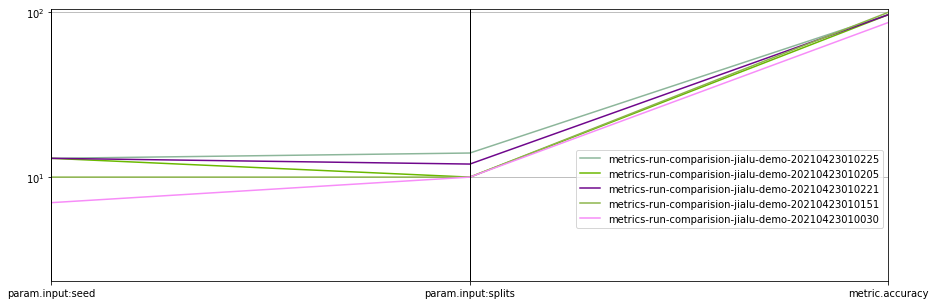

In [ ]:
plt.rcParams["figure.figsize"] = [15, 5]

pipeline_df['param.input:seed'] = pipeline_df['param.input:seed'].astype(np.float16)
pipeline_df['param.input:splits'] = pipeline_df['param.input:splits'].astype(np.float16) 

ax = pd.plotting.parallel_coordinates(
    pipeline_df.reset_index(level=0),
    'run_name', cols=['param.input:seed','param.input:splits', 'metric.accuracy'],
    # color=['blue', 'green', 'pink', 'red'],
    )
ax.set_yscale('symlog')
ax.legend(bbox_to_anchor=(1.0, 0.5))

## Plot ROC curve and calculate AUC number

In addition to basic metrics, we can also extract complex metrics from managed pipeline and perform further analysis in the notebook. The following pipeline job was created by this [notebook](https://colab.sandbox.google.com/drive/1Sas6rk0w2puxnaJJMPVBuIk1womgKrzf#scrollTo=5ExuvJuNUEUE).

In [ ]:
pipeline_df = aiplatform.get_pipeline_df(pipeline="jialu-roc-metrics-demo")
pipeline_df

,pipeline_name,run_name,metric.confidenceMetrics
0,jialu-roc-metrics-demo,jialu-roc-metrics-demo-20210423004938,"[{'falsePositiveRate': 0.0, 'recall': 0.0, 'co..."


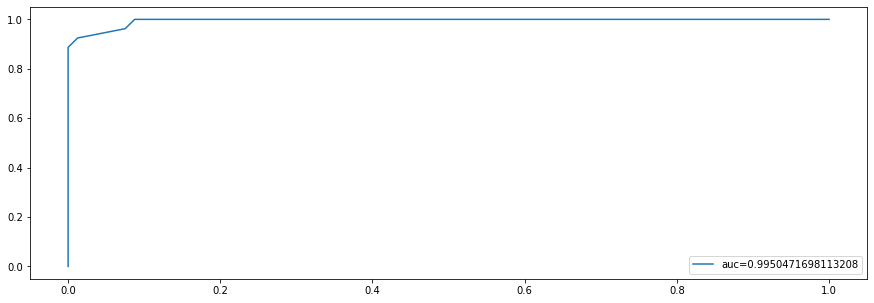

In [ ]:
df = pd.DataFrame(pipeline_df['metric.confidenceMetrics'][0])
auc = np.trapz(df['recall'],df['falsePositiveRate'])
plt.plot(df['falsePositiveRate'],df['recall'], label="auc="+str(auc))
plt.legend(loc=4)
plt.show() 